# Определение температуры звезды 

## Описание данных и подготовительные этапы

Прогнозирование температуры звезды

Поставленная задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры учёные пользуются следующими методами:
1. Закон смещения Вина.
2. Закон Стефана-Больцмана.
3. Спектральный анализ.


Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

В этом проекте необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.


Характеристики
1. Относительная светимость L/Lo — светимость звезды относительно Солнца.
2. Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
3. Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
4. Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
6. Тип звезды.

| Тип звезды | Номер, соответствующий типу |
| ---------- | --------------------------- |
| Коричневый карлик | 	0 |
Красный карлик	| 1
Белый карлик	| 2
Звёзды главной последовательности	| 3
Сверхгигант |	4
Гипергигант	| 5

7. Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Справочная информация:
* Светимость Солнца (англ. Average Luminosity of Sun) 
    
    Lo = 3.828⋅10ˆ26 Вт

* Радиус Солнца (англ. Average Radius of Sun) 
   
    Ro = 6.9551⋅10ˆ8 м

----

In [1]:
# установка необходимых пакетов с проверенными совместимыми версиями
%pip install -q \
    torch==2.4.1 \
    torchvision==0.19.1 \
    torchaudio==2.4.1 \
    
%pip install -q \
    scikit-learn==1.5.1 \
    pandas==2.2.2 \
    numpy==2.0.1 \
    matplotlib==3.9.2 \
    seaborn==0.13.2 \
    plotly==5.22.0 \
    phik==0.12.5 \
    ipython==8.26.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# импорты библиотек 
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from phik import phik_matrix
from itertools import product
from plotly.subplots import make_subplots
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler
)

In [3]:
# константы
RANDOM_STATE = 2026
TEST_SIZE = 0.4

In [4]:
def set_seed(seed):
    """
    Фиксирует зерно генератора случайных чисел для воспроизводимости
    в random, numpy и torch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(RANDOM_STATE)

Ниже приведены кастомные функции для работы с данными

### Функции визуализации результатов

In [5]:
#визуализация разницы прогноза и реальных значений
def plot_results_sns(y_true, y_pred, step=5):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    diff = y_true - y_pred
    df = pd.DataFrame({
        'Номер': range(len(y_true)),
        'Факт': y_true,
        'Прогноз': y_pred,
        'Разница': diff
    })
    df_melted = df.melt(id_vars=['Номер', 'Разница'], 
                        value_vars=['Факт', 'Прогноз'], 
                        var_name='Тип', 
                        value_name='Температура')
    plt.figure(figsize=(18, 6))
    ax1 = sns.barplot(data=df_melted, x='Номер', y='Температура', hue='Тип', 
                      palette='muted', alpha=0.7)
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='Номер', y='Разница', ax=ax2, 
                 color='red', marker='o', label='Разница (Факт - Прогноз)')
    ticks = np.arange(0, len(y_true), step) 
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(ticks)
    ax2.set_ylabel('Величина ошибки')
    ax2.set_ylim(diff.min() * 1.2, diff.max() * 1.2) 
    ax2.axhline(0, color='grey', linestyle='--', linewidth=1)
    plt.title(f'Сравнение прогноз-факт (RMSE: {np.sqrt(np.mean(diff*diff)):.2f} K)')
    plt.grid(axis='y', alpha=0.3)
    ax2.legend(loc='upper center')
    plt.show()

# функция визуализации результатов работы моделей
def compare_models_plotly(y_true, 
                          y_pred_1,
                          y_pred_2, 
                          model_names=['Модель 1', 'Модель 2'], 
                          x_label='Номер', 
                          y_label='Значение', 
                          title='Сравнение двух моделей: Факт vs Прогнозы',
                          show_stats=True,
                          sort_by_true=False):
    
    y_true = np.array(y_true).flatten()
    y_pred_1 = np.array(y_pred_1).flatten()
    y_pred_2 = np.array(y_pred_2).flatten()
    
    if sort_by_true:
        sort_idx = np.argsort(y_true)
        y_true = y_true[sort_idx]
        y_pred_1 = y_pred_1[sort_idx]
        y_pred_2 = y_pred_2[sort_idx]
        
    residuals_1 = y_true - y_pred_1
    residuals_2 = y_true - y_pred_2
    x_index = np.arange(len(y_true))
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(
            x=x_index, 
            y=y_true, 
            name='Факт',
            marker_color='skyblue',
            opacity=0.6
        ),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(
            x=x_index, 
            y=y_pred_1, 
            name=f'Прогноз {model_names[0]}',
            mode='lines+markers',
            marker=dict(size=6, symbol='circle'),
            line=dict(width=2, color='orange')
        ),
        secondary_y=False
    )

    fig.add_trace(
        go.Scatter(
            x=x_index, 
            y=y_pred_2, 
            name=f'Прогноз {model_names[1]}',
            mode='lines+markers',
            marker=dict(size=6, symbol='diamond'),
            line=dict(width=2, color='mediumpurple', dash='dot') 
        ),
        secondary_y=False
    )

    fig.update_layout(
        title=dict(text=title, x=0.5),
        barmode='overlay',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        height=600, 
        hovermode="x unified" # показывает все значения в одной точке
    )

    fig.update_xaxes(title_text=x_label, showgrid=False)
    
    fig.update_yaxes(
        title_text=y_label, 
        secondary_y=False, 
        showgrid=True, 
        gridcolor='LightGrey'
    )
    
    fig.update_yaxes(
        title_text="Величина ошибки", 
        secondary_y=True, 
        showgrid=False,
        zeroline=True, 
        zerolinecolor='grey'
    )
    
    fig.show()

    if show_stats:
        print(f"--- Сравнение метрик: {model_names[0]} vs {model_names[1]} ---")
        
        stats_df = pd.DataFrame({
            'Факт': y_true,
            f'Прогноз {model_names[0]}': y_pred_1,
            f'Прогноз {model_names[1]}': y_pred_2,
            f'Ошибка {model_names[0]}': residuals_1,
            f'Ошибка {model_names[1]}': residuals_2
        })
        display(stats_df.describe().T.round(2))

        def calc_metrics(res, true_val):
            mae = np.mean(np.abs(res))
            rmse = np.sqrt(np.mean(res ** 2))
            mask = true_val != 0
            mape = np.mean(np.abs(res[mask] / true_val[mask])) * 100 if np.any(mask) else np.nan
            return mae, rmse, mape

        mae1, rmse1, mape1 = calc_metrics(residuals_1, y_true)
        mae2, rmse2, mape2 = calc_metrics(residuals_2, y_true)
        
        metrics_df = pd.DataFrame({
            'Метрика': ['RMSE', 'MAE', 'MAPE (%)'],
            f'{model_names[0]}': [rmse1, mae1, mape1],
            f'{model_names[1]}': [rmse2, mae2, mape2],
            'Разница (M1 - M2)': [rmse1-rmse2, mae1-mae2, mape1-mape2]
        })
        
        print("\nИтоговые метрики (чем меньше, тем лучше):")
        display(metrics_df.round(4))

### Основные функции для работы с данными

In [6]:
def normalize_column_names(column_name):
    """
    функция автоматически исправляет названия столбцов 
                            (нижний регистр, убирает спец символы, snake_case)
    """
    normalized = column_name.replace(' ', '_').strip('_')
    normalized = normalized.lower()
    return normalized


def express_analysis(df, name='DateFrame'):
    '''
        Функция для экспресс анализа датафрема (кастомный .info())
    '''

    print(name)
    original_columns = list(df.columns)
    new_columns = [normalize_column_names(col) for col in df.columns]
    df.columns = new_columns

    data = {
        'new_name_columns' : new_columns,
        'type' : df.dtypes.values, 
        'count_dupl' : [],
        'count_nan' : []
    }
    
    for x in df.columns:
        data['count_dupl'].append(df[x].duplicated().sum())
        data['count_nan'].append(df[x].isna().sum())
    stats_df = pd.DataFrame(data, index=original_columns)
    result_df = pd.DataFrame(
        [{
            'new_name_columns' : '-',
            'type' : '-',
            'count_dupl' : df.duplicated().sum(),
            'count_nan' : df.isna().sum().sum()
        }], index=['Itog']
    )
    print('Исходные данные')
    display(df.sample(5))
    print('----' * 30)
    print('Сводные данные')
    print_df = pd.concat([stats_df, result_df]) 
    display(print_df)

def check_corr(df, target=None, phik=False, drop=[]):

    '''
        Подсчет корреляции и ее визуализация, с возможностью оценки 
        только количественных, так и количественно-качественных признаков
    '''

    drop = drop or []
    df = df.drop(columns=drop)

    if phik:
        matrix = df.phik_matrix()
        title = "Fk-корреляция (для категориальных + смешанных данных)"
        vmin, vmax = 0, 1
        center = None
        cmap = 'Blues'
    else:
        matrix = df.corr(method='pearson')
        title = "Корреляция Пирсона"
        vmin, vmax = 0, 1
        center = 0
        cmap = 'RdBu_r'

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matrix,
        annot=True,
        fmt='.2f',
        cmap=cmap,
        center=center,
        vmin=vmin, vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    display(matrix)

    if target:
        matrix = matrix[target].drop(target).sort_values(ascending=False)
        result = pd.DataFrame({
            'feat' : matrix.index,
            'first_corr' : matrix.values,
            'corr' : matrix.abs().values
        })  
        
        def cheddok(val):
            if val < 0.1:  return "Очень слабая"
            elif val < 0.3: return "Слабая"
            elif val < 0.5: return "Умеренная"
            elif val < 0.7: return "Заметная"
            elif val < 0.9: return "Высокая"
            else: return "Весьма высокая"
        
        result['cheddok'] = result['corr'].apply(cheddok)

        result['direction'] = result['first_corr'].apply(
            lambda x: 'Положительная' if x > 0 else 'Отрицательная'
            )
        
        result = result.sort_values('corr', ascending=False)
        result.drop(columns={'first_corr'}, inplace=True)
        display(result.round(3))


def visual_analysis(df, drop_list=[]):
    '''
        функция анализа данных с автоматическим разделением 
            на числовые, объектные и категориальные признаки
    '''
    for col in df.drop(columns=drop_list).columns:
        if df[col].dtype.name == 'object':
            value_counts = df[col].value_counts()
            if len(value_counts) > 7:  
                other = value_counts[value_counts < value_counts.sum() * 0.05].sum()
                value_counts = value_counts[value_counts >= value_counts.sum() * 0.05]
                value_counts['Other'] = other
            colors = sns.color_palette('Set3', len(value_counts))
            plt.figure(figsize=(6, 4))
            plt.pie(value_counts.values, labels=value_counts.index, 
                    autopct='%1.1f%%', startangle=90, colors=colors)
            plt.legend(value_counts.index, title=col, loc='best', bbox_to_anchor=(1, 1))
            plt.title(f'{col} - Pie')
            plt.axis('equal')  
            plt.show()
            print(value_counts)
        elif df[col].dtype.name == 'category':
            plt.figure(figsize=(8, 4))
            sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)
            
            plt.title(f'{col} - Bar Chart (Category)')
            plt.xlabel(col)
            plt.ylabel('Количество')
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()
            
            print(f"\n--- Статистика для {col} ---")
            print(df[col].describe()) 
            print("\nРаспределение (топ-10):")
            print(df[col].value_counts().head(10))

        elif df[col].dtype in ['int64', 'float64']:
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})
            
            sns.histplot(data=df, x=col, bins='auto', ax=ax1, kde=True)
            ax1.set_title(f'{col} - Histogram')
            ax1.set_xlabel(col)
            ax1.set_ylabel('Частота')
            ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

            sns.boxplot(data=df, x=col, ax=ax2)
            ax2.set_title(f'{col} - BoxPlot')
            ax2.set_ylabel('')
            
            plt.tight_layout()
            plt.show()
            print(f"\n Описание для {col}:")
            print(df[col].describe())
        else:
            print(f"Пропущен столбец {col}: неподдерживаемый тип {df[col].dtype}")
            continue


## Загрузка данных

In [7]:
try:
    df = pd.read_csv('datasets/6_class.csv')
except:
    df = pd.read_csv('/datasets/6_class.csv')

In [8]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


Данные загружены, качество данных посмотри при EDA

## EDA

### Общий анализ данных

In [9]:
express_analysis(df, 'stars')

stars
Исходные данные


,unnamed:_0,temperature_(k),luminosity(l/lo),radius(r/ro),absolute_magnitude(mv),star_type,star_color
37,37,6380,1.35,0.98,2.93,3,yellow-white
167,167,26373,198000.00,39.00,-5.83,4,Blue
222,222,9383,342940.00,98.00,-6.98,4,Blue
42,42,3270,150000.00,88.00,-6.02,4,Red
234,234,21904,748490.00,1130.00,-7.67,5,Blue-white


------------------------------------------------------------------------------------------------------------------------
Сводные данные


,new_name_columns,type,count_dupl,count_nan
Unnamed: 0,unnamed:_0,int64,0,0
Temperature (K),temperature_(k),int64,12,0
Luminosity(L/Lo),luminosity(l/lo),float64,32,0
Radius(R/Ro),radius(r/ro),float64,24,0
Absolute magnitude(Mv),absolute_magnitude(mv),float64,12,0
Star type,star_type,int64,234,0
Star color,star_color,object,221,0
Itog,-,-,0,0


Пропуски в данных отсутствуют. Явных дубликатов нет. В названиях дубликатов нет.   Есть обоснованные дубликаты в остальных столбцах (такие показатели как температура и радиус могут повторяться).


star_type, star_color - категория, приведем к нужному типу

Названия столбцов в данном случае не изменились автоматически из-за наличий скобок и прочего, проще изменить вручную, после чего приступим к изучению данных

In [10]:
df['star_type'] = df['star_type'].astype('category')
df['star_color'] = df['star_color'].astype('category')
df.columns = ['id', 'temperature', 'luminosity', 'radius',
       'absolute_magnitude', 'star_type', 'star_color']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   id                  240 non-null    int64   
 1   temperature         240 non-null    int64   
 2   luminosity          240 non-null    float64 
 3   radius              240 non-null    float64 
 4   absolute_magnitude  240 non-null    float64 
 5   star_type           240 non-null    category
 6   star_color          240 non-null    category
dtypes: category(2), float64(3), int64(2)
memory usage: 10.9 KB


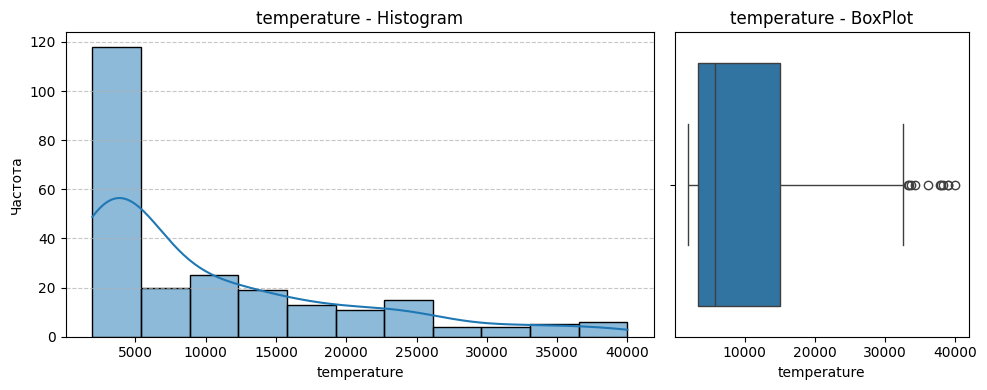


 Описание для temperature:
count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64


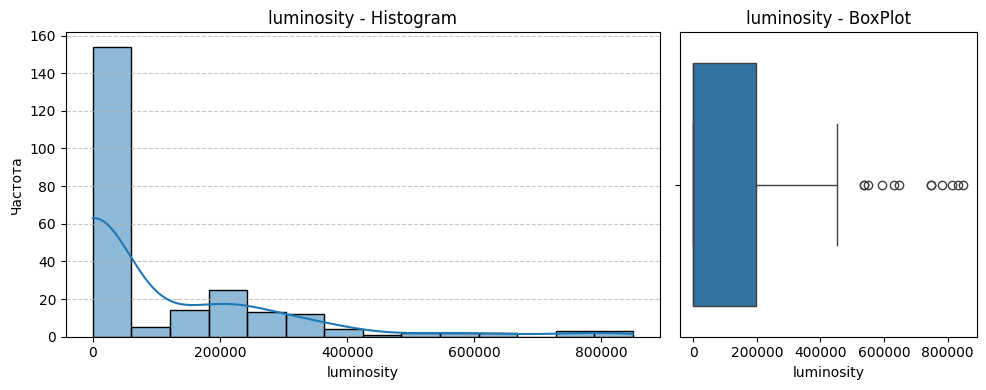


 Описание для luminosity:
count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64


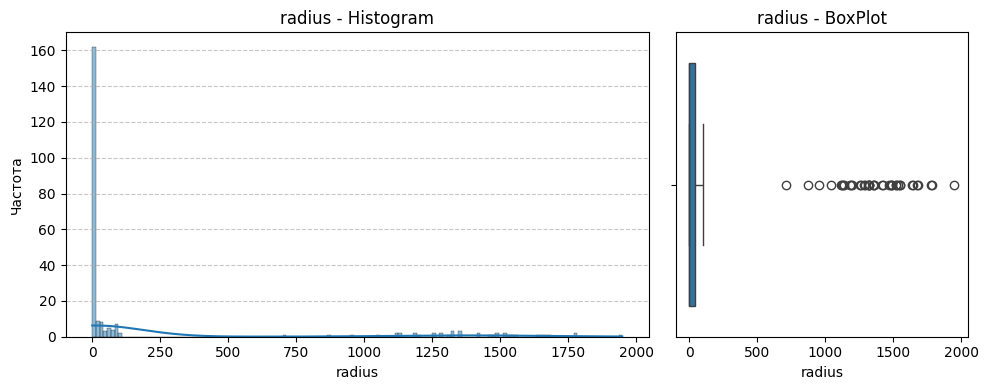


 Описание для radius:
count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64


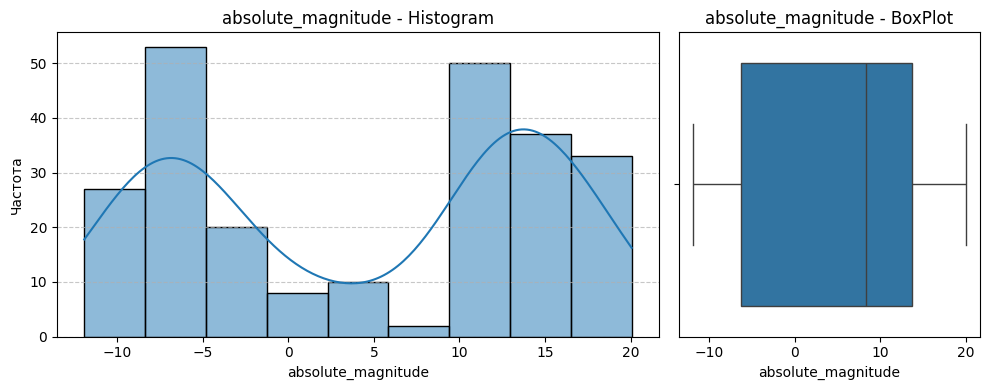


 Описание для absolute_magnitude:
count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64


/var/folders/4k/495js9pn5gv0v3107j2ysgqm0000gn/T/ipykernel_34663/2456965990.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)


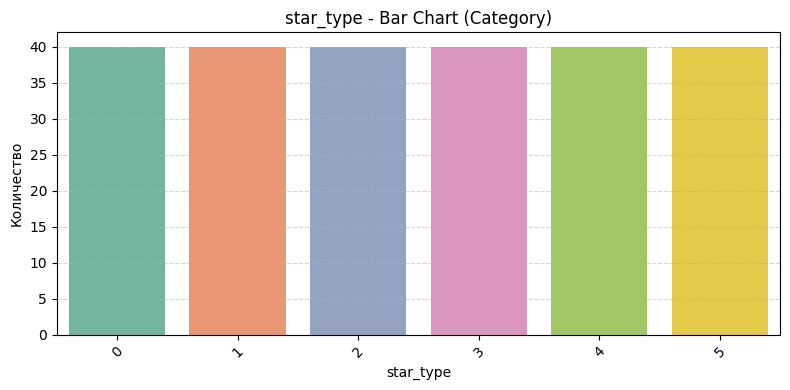


--- Статистика для star_type ---
count     240
unique      6
top         0
freq       40
Name: star_type, dtype: int64

Распределение (топ-10):
star_type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


/var/folders/4k/495js9pn5gv0v3107j2ysgqm0000gn/T/ipykernel_34663/2456965990.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette='Set2', order=df[col].value_counts().index)


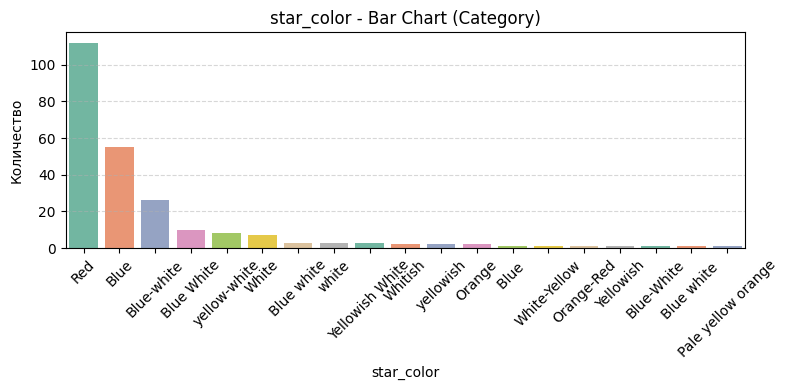


--- Статистика для star_color ---
count     240
unique     19
top       Red
freq      112
Name: star_color, dtype: object

Распределение (топ-10):
star_color
Red                112
Blue                55
Blue-white          26
Blue White          10
yellow-white         8
White                7
Blue white           3
white                3
Yellowish White      3
Whitish              2
Name: count, dtype: int64


In [11]:
visual_analysis(df, ['id'])

Из анализа полученных данных можно выделить следующие наблюдения:
* заметны обоснованные смещения в данных, необходимо проверить зависимость радиуса, от типа звезды и цвета звезды
* медианная температура составляет 5776 Кельвинов (таргетальный признак)
* значения освещенности имеют LongTail, данные значения приведем к логарифмичной форме, чтобы снизить разброс значений
* большая часть планет имеет радиус - от 0.1 до 42.75 радиусов относительно солнца (характеристики солнца известные величины, при необходимости всегда есть возможность получить абсолютные, а не относительные значения), данные значения приведем к логарифмичной форме, чтобы снизить разброс значений
* распредление абсолютной звёздной величины равномерно концентрируется вокруг значений с шагом 5, поэтому данный столбец можно привести к категориальному типу
* Тип звезд распределен равномерно - по 40 элементов каждого типа
* Цвета звезд имеют неявные дубликаты, необходдимо рассмотреть эти данные внимательнее

### Детальное изучение данных

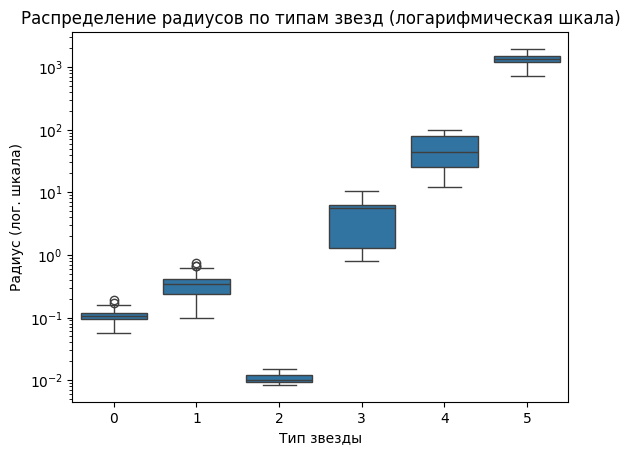

In [12]:
sns.boxplot(data=df, x='star_type', y='radius')
plt.yscale('log')
plt.title('Распределение радиусов по типам звезд (логарифмическая шкала)')
plt.xlabel('Тип звезды')
plt.ylabel('Радиус (лог. шкала)')
plt.show()

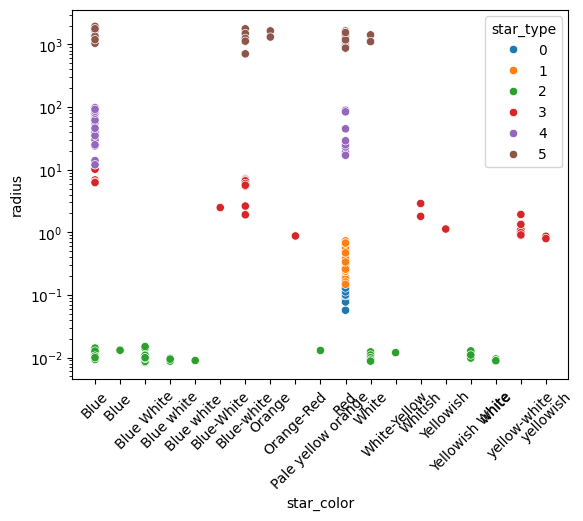

In [13]:
sns.scatterplot(df, x='star_color', y='radius', hue='star_type')
plt.xticks(rotation=45)
plt.yscale('log')


In [14]:
df.loc[df['star_type'] == 2].sample(10)

,id,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
143,143,14520,0.00082,0.00972,11.92,2,Blue White
207,207,23092,0.00132,0.01040,10.18,2,Blue
209,209,19360,0.00125,0.00998,11.62,2,Blue
88,88,13720,0.00018,0.00892,12.97,2,white
149,149,12984,0.00088,0.00996,11.23,2,Blue White
203,203,13340,0.00109,0.01160,12.90,2,Blue
147,147,14732,0.00011,0.00892,12.89,2,white
144,144,11900,0.00067,0.00898,11.38,2,Blue white
22,22,7220,0.00017,0.01100,14.23,2,White
146,146,12912,0.00071,0.00945,12.83,2,Blue white


График показывает малый радиус для звезд типа 2. Это обосновано физикой: эти звезды имеют белый/голубой цвет, что говорит о высокой температуре поверхности. Однако их общая светимость низка. Сочетание высокой температуры и низкой светимости физически возможно только если объект имеет очень маленький радиус (это Белые карлики).

Перейдем к очистке данных связанных с цветом звезды. Также воспользуемся смещением по [закону смещения Вина](https://ru.wikipedia.org/wiki/Закон_смещения_Вина) и на основе цвета выделим опорные значения температур. 

In [15]:
display([i for i in sorted(df['star_color'].unique())])

['Blue',
 'Blue ',
 'Blue White',
 'Blue white',
 'Blue white ',
 'Blue-White',
 'Blue-white',
 'Orange',
 'Orange-Red',
 'Pale yellow orange',
 'Red',
 'White',
 'White-Yellow',
 'Whitish',
 'Yellowish',
 'Yellowish White',
 'white',
 'yellow-white',
 'yellowish']

In [16]:
df['star_color'] = (df['star_color']
                    .str.strip()
                    .str.lower()
                    .str.replace("-", " ")
                    .str.replace("_", " ")
                    .str.replace("yellowish", "yellow")
                    .str.replace("whitish", "white")
                    .str.replace("pale", ""))

df['star_color'] = df['star_color'].apply(lambda x: " ".join(sorted(x.split())))
df['star_color'].value_counts()

star_color
red              112
blue              56
blue white        41
white             12
white yellow      12
yellow             3
orange             2
orange yellow      1
orange red         1
Name: count, dtype: int64

In [17]:
df['star_color'] = (df['star_color']
                    .str.replace("orange yellow", "yellow")
                    .str.replace("orange", "yellow")
                    .str.replace("yellow red", "yellow")
                    .str.replace("orange red", "yellow"))
df['star_color'].value_counts()

star_color
red             112
blue             56
blue white       41
white            12
white yellow     12
yellow            7
Name: count, dtype: int64

In [18]:
# на основании закона Вина словарь соответствия порядка температур относительно цвета планеты
wien_displacement_map = {
    'red': 3000,
    'white yellow': 6000, 
    'yellow' : 6500,
    'white': 10000,
    'blue white': 20000,
    'blue': 30000
}

df['approx_temp'] = df['star_color'].map(wien_displacement_map)
df['approx_temp'] = df['approx_temp'].fillna(df['approx_temp'].median())


На основе [закона Стефана-Больцмана](https://ru.wikipedia.org/wiki/Закон_Стефана_—_Больцмана) о плотности потока энергии получим фичу, влияющую на температуру. Из формулы:

$$T^4 = \frac{L}{4\pi \sigma R^2}$$

уберем константы и оставим зависимость температуры от частного светимости к квадрату радиуса

In [19]:
df['physics_feature'] = df['luminosity'] / (df['radius'] ** 2)

In [20]:
# приведем к логарифмичному виду фичи, старые значения удалим
df['luminosity'] = np.log10(df['luminosity'])
df['radius'] = np.log10(df['radius'])
df['approx_temp_log'] = np.log1p(df['approx_temp'])
df['physics_feature_log'] = np.log1p(df['physics_feature'])

df = df.drop(columns=['physics_feature'])
df = df.drop(columns=['approx_temp'])

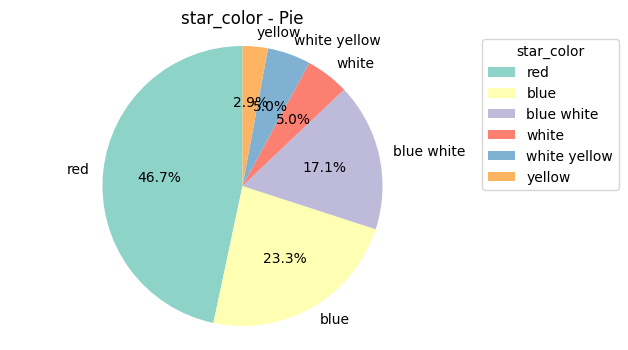

star_color
red             112
blue             56
blue white       41
white            12
white yellow     12
yellow            7
Name: count, dtype: int64


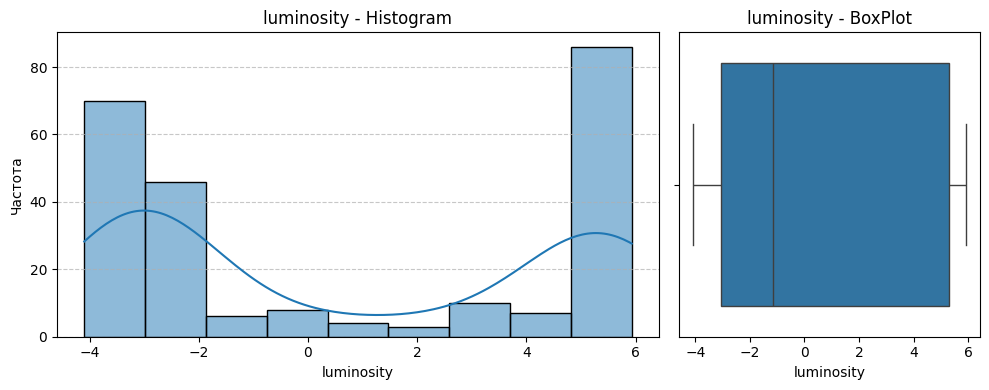


 Описание для luminosity:
count    240.000000
mean       0.707110
std        3.964021
min       -4.096910
25%       -3.063134
50%       -1.161197
75%        5.296775
max        5.929122
Name: luminosity, dtype: float64


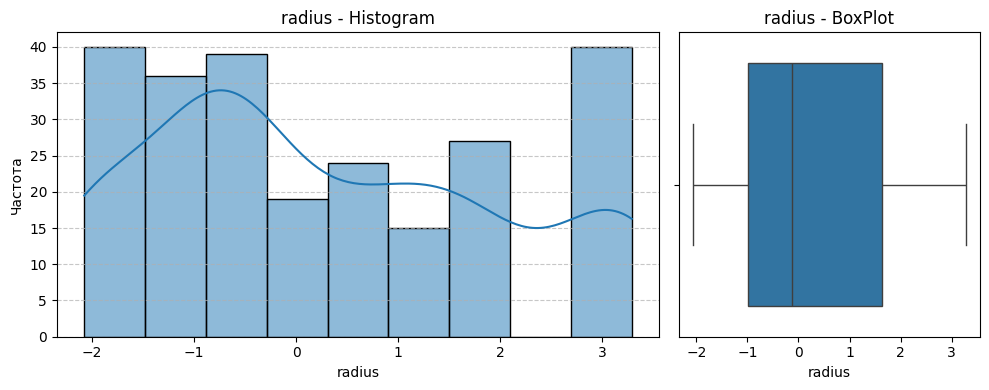


 Описание для radius:
count    240.000000
mean       0.306194
std        1.712423
min       -2.075721
25%       -0.988222
50%       -0.118155
75%        1.630740
max        3.289700
Name: radius, dtype: float64


In [21]:
visual_analysis(df[['star_color', 'luminosity', 'radius']])

### Корреляция признаков

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'approx_temp_log', 'physics_feature_log']


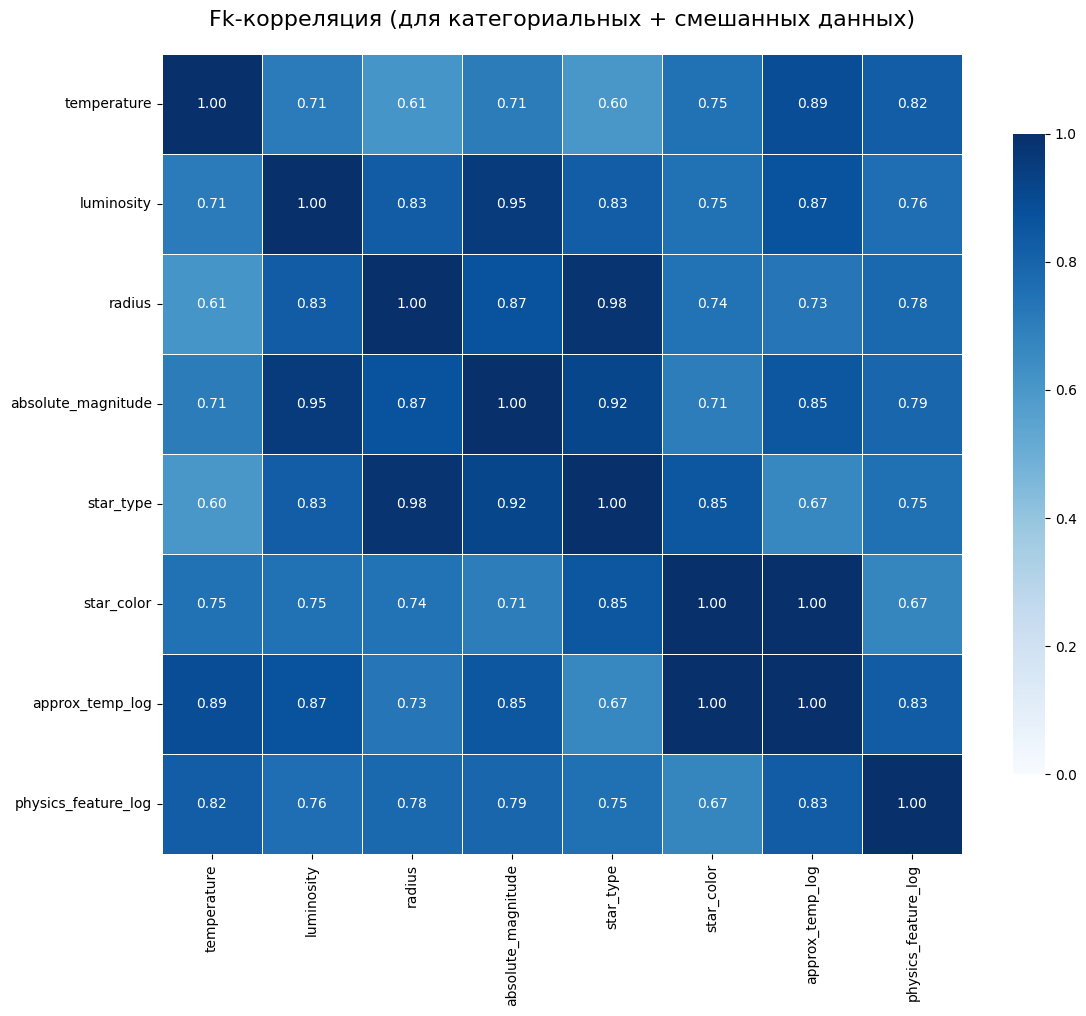

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,approx_temp_log,physics_feature_log
temperature,1.000000,0.711445,0.611434,0.710472,0.603924,0.746706,0.889593,0.824298
luminosity,0.711445,1.000000,0.831949,0.954589,0.826545,0.747868,0.869808,0.761372
radius,0.611434,0.831949,1.000000,0.867458,0.982399,0.742735,0.734229,0.783129
absolute_magnitude,0.710472,0.954589,0.867458,1.000000,0.915921,0.706337,0.849133,0.790519
star_type,0.603924,0.826545,0.982399,0.915921,1.000000,0.850026,0.666811,0.751123
star_color,0.746706,0.747868,0.742735,0.706337,0.850026,1.000000,1.000000,0.674047
approx_temp_log,0.889593,0.869808,0.734229,0.849133,0.666811,1.000000,1.000000,0.829192
physics_feature_log,0.824298,0.761372,0.783129,0.790519,0.751123,0.674047,0.829192,1.000000


,feat,corr,cheddok,direction
0,approx_temp_log,0.890,Высокая,Положительная
1,physics_feature_log,0.824,Высокая,Положительная
2,star_color,0.747,Высокая,Положительная
3,luminosity,0.711,Высокая,Положительная
4,absolute_magnitude,0.710,Высокая,Положительная
5,radius,0.611,Заметная,Положительная
6,star_type,0.604,Заметная,Положительная


In [22]:
check_corr(df, target='temperature', drop=['id'], phik=True)

### Промежуточный вывод по EDA

Экспресс-анализ показал, что датасет чистый: отсутствуют пропуски и дубликаты. Распределения числовых признаков (светимость, радиус, абсолютная величина) имеют сильный разброс и скошенность, что характерно для астрономических данных. Категориальные признаки «цвет звезды» и «тип звезды» содержат небольшое количество уникальных значений, что удобно для кодирования.

Корреляционный анализ (включая Phik-коэффициент) выявил сильные взаимосвязи температуры с другими признаками: высокая отрицательная корреляция с абсолютной звёздной величиной, положительная — со светимостью и радиусом. Это подтверждает физическую обоснованность данных и даёт уверенность в том, что признаки информативны для предсказания целевой переменной. Данные готовы к моделированию.

## Построение базовой нейронной сети

Для построения базового решения (Baseline) мы использовали архитектуру полносвязной нейросети с двумя скрытыми слоями (128 и 64 нейрона), обучение и оцценка будет метрикой RMSE, согласно заданию, хотя в данном случае я бы выбрал функцию потерь MAE для эффективной минимизации грубых ошибок и оценивая качество по той же понятной метрике. Для обеспечения строгой воспроизводимости результатов эксперимента была проведена полная фиксация генераторов случайных чисел.

In [23]:
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1

def rmse(predictions, targets):
    mse = F.mse_loss(predictions, targets)
    return torch.sqrt(mse)

In [24]:
df

,id,temperature,luminosity,radius,absolute_magnitude,star_type,star_color,approx_temp_log,physics_feature_log
0,0,3068,-2.619789,-0.769551,16.12,0,red,8.006701,0.079777
1,1,3042,-3.301030,-0.811916,16.60,0,red,8.006701,0.020810
2,2,2600,-3.522879,-0.991400,18.70,0,red,8.006701,0.028427
3,3,2800,-3.698970,-0.795880,16.65,0,red,8.006701,0.007782
4,4,1939,-3.860121,-0.987163,20.06,0,red,8.006701,0.012924
...,...,...,...,...,...,...,...,...,...
235,235,38940,5.573834,3.132260,-9.93,5,blue,10.308986,0.185526
236,236,30839,5.921188,3.077004,-10.63,5,blue,10.308986,0.460604
237,237,8829,5.730373,3.153205,-10.73,5,white,9.210440,0.235418
238,238,9235,5.607391,3.046105,-11.23,5,white,9.210440,0.283280


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['temperature', 'star_color']), 
                                                    df['temperature'], 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify = df['star_color'])

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

num_cols = ['luminosity','radius', 'physics_feature_log', 'approx_temp_log']
ohe_cols = ['star_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), ohe_cols)
    ]
)

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

X_train_t = torch.tensor(X_train_pre, dtype=torch.float32)
X_test_t = torch.tensor(X_test_pre, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

print(f"X shape: {X_train_t.shape}")
print(f"y shape: {y_train_t.shape}")

Train: (144, 7), Test: (96, 7)
X shape: torch.Size([144, 9])
y shape: torch.Size([144, 1])


In [26]:
set_seed(RANDOM_STATE)
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu1= nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
print('--'*20)

model = NeuralNet(X_train_t.shape[1], hidden_size_1, hidden_size_2, output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
loss = rmse
num_epochs = 500

for i in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    preds = model.forward(X_train_t)
    loss_val = rmse(preds, y_train_t)  
    loss_val.backward()
    optimizer.step()
    if i % 100 == 0 or i == num_epochs:
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test_t)
            test_rmse = rmse(pred_test, y_test_t)
            print(f"Epoch {i}, Loss: {loss_val.item():.4f}, Val RMSE: {test_rmse.item():.4f}")


----------------------------------------
Epoch 0, Loss: 14450.0459, Val RMSE: 13764.2666
Epoch 100, Loss: 5088.1260, Val RMSE: 5554.4604
Epoch 200, Loss: 4092.4265, Val RMSE: 4776.1455
Epoch 300, Loss: 3886.3855, Val RMSE: 4622.9961
Epoch 400, Loss: 3667.7437, Val RMSE: 4476.1860


In [27]:
model.eval()
with torch.no_grad():
    pred_test = model(X_test_t)
    test_rmse = rmse(pred_test, y_test_t)
print('--'*20)
print(f'Result RMSE in Baseline-model : {test_rmse.item():.0f} Kelvin')

----------------------------------------
Result RMSE in Baseline-model : 4391 Kelvin


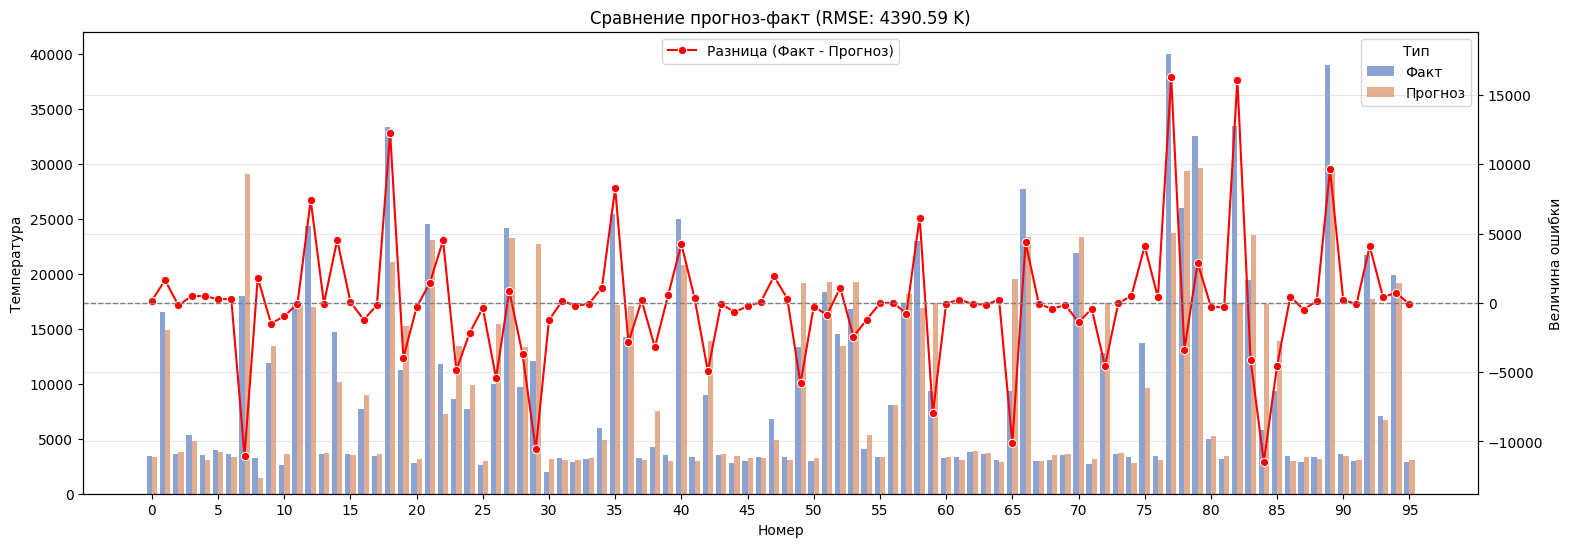

In [28]:
pred_baseline = pred_test.detach().numpy().flatten().reshape(-1).astype('int')
plot_results_sns(y_test, pred_baseline)

Модель достигла RMSE ≈ 4391 К. 

### Промежуточный вывод по базовой модели

Линейная регрессия в качестве baseline показала RMSE ≈ 4391 K на тестовых данных. Это приемлемый начальный результат, учитывая широкий диапазон температур (от 2650 до 40 000 K). Однако значительные ошибки на объектах с экстремальными значениями указывают на нелинейный характер зависимостей. Дальнейшее улучшение возможно за счёт использования более сложных моделей, способных улавливать нелинейные взаимосвязи.

## Улучшение нейронной сети

Сменим подход к реализации обучения нейронной сети и подбора параметров. Реализуем полный класс, который может нам получить все необходимые данные и добиться улучшения показателей.
Реализуем автоматический:
* подбор гиперпараметров
* применение dropout
* подбор параметра шага обучения
* добавим нормализацию батчей

In [29]:
class UniNeo(nn.Module):
    def __init__(self,
                 n_neurons, #список скрытых нейронов на слоях
                 activation='relu', #функция активации
                 activation_parm = {},  #параметры функций активации
                 dropout_rate=0.0, # значение dropout
                 weight_init='normal', # метод иницилизации весов
                 bias_init='zeros', # метод иницилизации смещения
                 output_activation=None, # функция активации на последнем слое 
                 use_batchnorm=False, # использование batchnorm
                 btch_moment=0.1):  # момент использования batchnorm
        super().__init__()
        layers = []

        for i in range(len(n_neurons) - 1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if use_batchnorm and i < (len(n_neurons) - 2):
                layers.append(nn.BatchNorm1d(n_neurons[i+1], momentum=btch_moment))
            
            if  i < (len(n_neurons) - 2):
                if activation == 'relu': layers.append(nn.ReLU())
                elif activation == 'tanh': layers.append(nn.Tanh())
                elif activation == 'sig': layers.append(nn.Sigmoid())
                elif activation == 'elu': layers.append(nn.ELU(alpha=activation_parm.get('alpha', 1.0)))
                elif activation == 'silu': layers.append(nn.SiLU())
                elif activation == 'leaky_relu': layers.append(nn.LeakyReLU(negative_slope=activation_parm.get('alpha', 0.01)))

                if dropout_rate > 0.0: layers.append(nn.Dropout(p=dropout_rate))
            else: #в задачах регрессии редко используется активация выходного слоя
                if output_activation == 'sig':
                    layers.append(nn.Sigmoid())
                elif output_activation == 'soft':
                    layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)
        self._init_weight(weight_init, bias_init, activation)
        self.use_batchnorm = use_batchnorm
        self.btch_moment = btch_moment
        self.dropout_rate = dropout_rate
        self.activation = activation
    
    def _init_weight(self, weight_init, bias_init, activation):
        def init_fn(layer):
            if isinstance(layer, nn.Linear):
                no_linearity = 'relu'
                if activation == 'tanh': no_linearity = 'tanh'
                elif activation == 'sig': no_linearity = 'sigmoid'
                elif activation == 'leaky_relu': no_linearity = 'leaky_relu'

                if weight_init == 'normal': nn.init.normal_(layer.weight, mean=0.0, std = 0.03)
                elif weight_init == 'xavier': nn.init.xavier_uniform_(layer.weight)
                elif weight_init == 'kaiming': nn.init.kaiming_normal_(layer.weight, nonlinearity=no_linearity)
                if layer.bias is not None:
                    if bias_init == 'normal': nn.init.normal_(layer.bias, mean=0.0, std = 0.03)
                    elif bias_init == 'zeros': nn.init.zeros_(layer.bias)
                    elif bias_init == 'constant': nn.init.constant_(layer.bias, 0.1)
        self.model.apply(init_fn)

    def forward(self, x):
        return self.model(x).flatten()
    
    def train_model(self, 
                    X_train, 
                    y_train, 
                    X_test, 
                    y_test,
                    learning_rate=1e-3, 
                    num_epochs=1000, 
                    batch_size=32,
                    loss_fn=None, 
                    optimizer_type='Adam', 
                    print_every=200):
        if loss_fn is None:
            loss_fn = nn.MSELoss()
        if optimizer_type == 'Adam': optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer_type == 'SGD': optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

        history = []
        use_full_batch = (batch_size <= 0)
        if use_full_batch: num_batches = 1
        else:
            train_dataset = TensorDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            num_batches = len(train_loader)
        
        for epoch in range(num_epochs):
            self.train()
            total_loss = 0
            if use_full_batch:
                X_batch = X_train
                y_batch = y_train
                optimizer.zero_grad()
                preds = self.forward(X_batch)
                loss_val = loss_fn(preds, y_batch.flatten())
                loss_val.backward()
                optimizer.step()
                total_loss += loss_val.item()
            else:
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    preds = self.forward(X_batch)
                    loss_value = loss_fn(preds, y_batch.flatten())
                    loss_value.backward()
                    optimizer.step()
                    total_loss += loss_value.item()

            self.eval()
            with torch.no_grad():

                train_preds = self.forward(X_train).flatten()
                train_rmse = torch.sqrt(loss_fn(train_preds, y_train.flatten()))

                test_preds = self.forward(X_test).flatten()
                test_rmse = torch.sqrt(loss_fn(test_preds, y_test.flatten()))
            
            avg_loss = total_loss / num_batches
            history.append({
                'epoch': epoch + 1,
                'loss': avg_loss,
                'rmse_train': train_rmse.item(),
                'rmse_test': test_rmse.item()
            })
            if epoch % print_every == 0 or epoch == num_epochs - 1:
                bn_status = "BN" if self.use_batchnorm else "No BN"
                print(f'Эпоха: {epoch:4d}, loss: {avg_loss:.4f}, '
                      f'RMSE (train): {train_rmse:.4f}, RMSE (test): {test_rmse:.4f} [{bn_status}]')
            
        history_df = pd.DataFrame(history)
        self.eval()
        return history_df
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self.forward(X).flatten()

    def metrics(self, X, y, loss_fn=None):
        if loss_fn is None:
            loss_fn = nn.MSELoss()
        
        self.eval()
        with torch.no_grad():
            preds = self.predict(X)
            mse = loss_fn(preds, y.flatten())
            rmse = torch.sqrt(mse)
            return {'MSE': mse.item(), 'RMSE': rmse.item()}
    
    def architecture(self):
        info = f'Architecture:\n{str(self.model)}'
        info += f'\n\nDetails:'
        if self.use_batchnorm: info += f'\nBatchnorm: True (moment={self.btch_moment})' 
        else: info += f'\nBatchnorm: False)' 

        if self.dropout_rate > 0.0: info += f'\nDropout: {self.dropout_rate}'
        else: info += f'\nDropout: False)' 

        info += f'\nActivation: {self.activation}'

        return info


In [30]:
# функция подбора лучших гиперпараметров для сетей

def searcher(
        X_train,
        y_train,
        X_test,
        y_test,
        grid,
        num_epochs=500,
        printers=250,
        loss = nn.MSELoss()):

    best_model = None
    best_params = None
    best_rmse = float('inf')
    history_learning = []
    keys, values = zip(*grid.items())
    total_parameters = np.prod([len(x) for x in values])
    print(f'All recipes is {total_parameters}')
    for combo_idx, combo in enumerate(product(*values)):
        params = dict(zip(keys, combo))
        print(f"\n[{combo_idx+1}/{total_parameters}] Считаем: {params}")

        input_size = X_train.shape[1]
        output_size = 1 
        hidden_layers = params.get('hidden_layers', [64, 32]) 
        n_neurons_list = [input_size] + hidden_layers + [output_size]

        activation_params = {}
        if params['activation'] == 'LeakyReLU':
            activation_params = {'alpha': params.get('leaky_alpha', 0.01)}
        
        model = UniNeo(
            n_neurons_list,
            activation=params['activation'],
            dropout_rate=params['dropout_rate'],
            use_batchnorm=params['use_batchnorm'],
            activation_parm=activation_params
        )
        history = model.train_model(
            X_train, y_train, X_test, y_test,
            learning_rate=params['learning_rate'],
            num_epochs=num_epochs,
            batch_size=params['batch_size'],
            print_every = printers,
            loss_fn=loss,
        )

        metrics = model.metrics(X_test, y_test)
        test_rmse = metrics['RMSE']

        print(f"RMSE (test): {test_rmse:.4f}")

        for _, row in history.iterrows():
            history_learning.append({
                'combo_idx': combo_idx + 1,
                'params': str(params),
                'epoch': row['epoch'],
                'loss': row['loss'],
                'rmse_train': row['rmse_train'],
                'rmse_test': row['rmse_test']
            })

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = params
            best_model = model

    print("Лучшие параметры модели:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"Лучший показатель RMSE: {best_rmse:.4f}")

    history_df = pd.DataFrame(history_learning)
    return best_model, best_params, history_df
                    

In [31]:
set_seed(RANDOM_STATE)

grid = {
    'hidden_layers': [
        [64, 32],       
        [128, 64, 32],         
    ],
    'activation' : ['relu'],
    'dropout_rate' : [0.0, 0.1],
    'use_batchnorm' : [True, False],
    'batch_size' : [32, 64],
    'learning_rate' : [1e-3, 1e-2],
}

best_model, best_params, res = searcher(
    X_train_t,
    y_train_t,
    X_test_t,
    y_test_t,
    grid,
    1000,
    500
)


All recipes is 32

[1/32] Считаем: {'hidden_layers': [64, 32], 'activation': 'relu', 'dropout_rate': 0.0, 'use_batchnorm': True, 'batch_size': 32, 'learning_rate': 0.001}
Эпоха:    0, loss: 202524585.6000, RMSE (train): 14449.9111, RMSE (test): 13764.5547 [BN]
Эпоха:  500, loss: 209519582.4000, RMSE (train): 13839.0137, RMSE (test): 13280.4707 [BN]
Эпоха:  999, loss: 166486651.2000, RMSE (train): 12501.3135, RMSE (test): 12206.2861 [BN]
RMSE (test): 12206.2861

[2/32] Считаем: {'hidden_layers': [64, 32], 'activation': 'relu', 'dropout_rate': 0.0, 'use_batchnorm': True, 'batch_size': 32, 'learning_rate': 0.01}
Эпоха:    0, loss: 206326198.4000, RMSE (train): 14449.7871, RMSE (test): 13764.4463 [BN]
Эпоха:  500, loss: 13203511.5000, RMSE (train): 2786.6824, RMSE (test): 5839.3252 [BN]
Эпоха:  999, loss: 7625708.8000, RMSE (train): 2796.9519, RMSE (test): 6025.4287 [BN]
RMSE (test): 6025.4287

[3/32] Считаем: {'hidden_layers': [64, 32], 'activation': 'relu', 'dropout_rate': 0.0, 'use_batc

In [32]:
print(best_model.architecture())

Architecture:
Sequential(
  (0): Linear(in_features=9, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)

Details:
Batchnorm: False)
Dropout: False)
Activation: relu


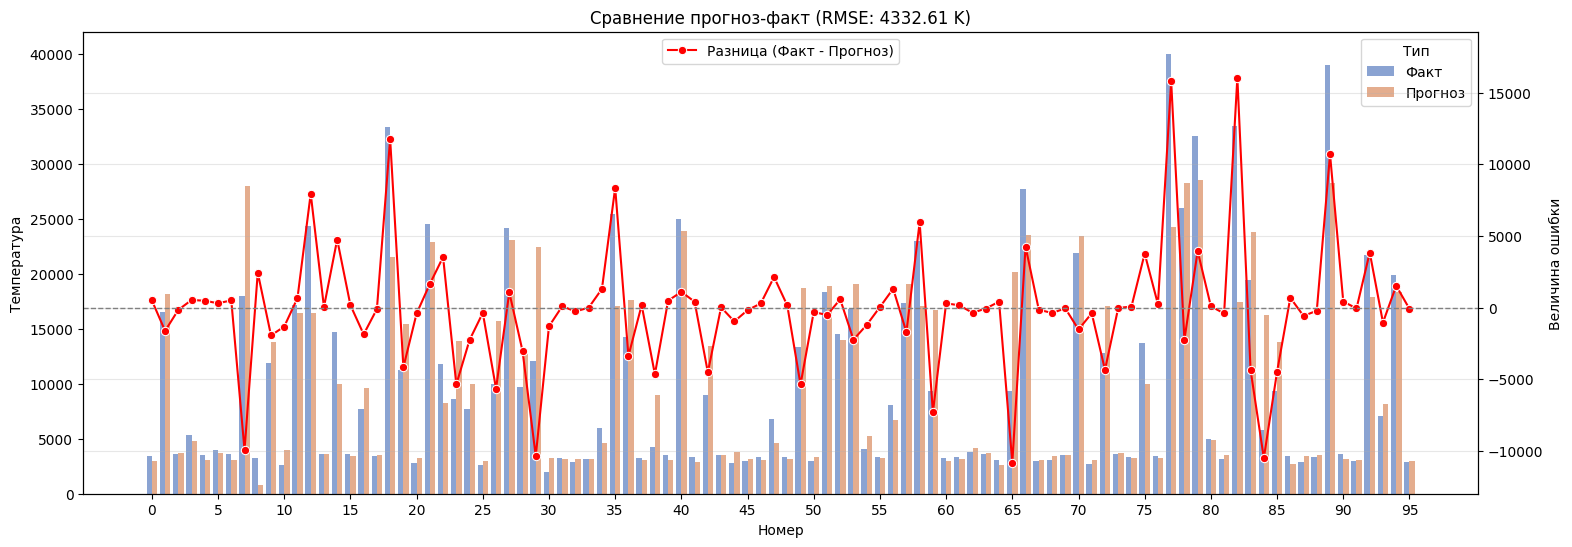

In [33]:
predict = best_model.predict(X_test_t)
final_mae_pipeline = root_mean_squared_error(y_test, predict)

plot_results_sns(y_test, predict)

В результате тщательного подбора гиперпараметров была получена улучшенная модель с метрикой RMSE = 4323 K. Лучшим решением стала полносвязная нейронная сеть с «сужающейся» архитектурой: входной слой принимает 9 признаков и последовательно преобразует их через скрытые слои размерностью 128 → 64 → 32 нейрона к финальному предсказанию. Конфигурация включает три слоя без Dropout для эффективной регуляризации и функцию активации ReLU после каждого линейного слоя, что обеспечивает стабильное обучение и способность моделировать сложные нелинейные зависимости. Batch Normalization в данной конфигурации не использовался.


Теперь сравним работы двух моделей

In [34]:
compare_models_plotly(
    y_test, 
    pred_test,
    predict,
    model_names=['Baseline', 'Best_model_pipe'],
)

--- Сравнение метрик: Baseline vs Best_model_pipe ---


,count,mean,std,min,25%,50%,75%,max
Факт,96.0,10150.12,9346.01,1939.00,3323.75,5140.00,14573.00,40000.00
Прогноз Baseline,96.0,10157.22,8173.31,1454.09,3263.73,5052.34,17200.63,29600.44
Прогноз Best_model_pipe,96.0,10185.80,8150.03,832.97,3233.53,4828.02,17056.09,28544.52
Ошибка Baseline,96.0,-7.09,4413.65,-11479.54,-1024.14,-62.96,491.95,16298.63
Ошибка Best_model_pipe,96.0,-35.68,4355.21,-10815.51,-1373.10,-37.26,542.11,16033.30



Итоговые метрики (чем меньше, тем лучше):


,Метрика,Baseline,Best_model_pipe,Разница (M1 - M2)
0,RMSE,4390.6034,4332.6150,57.9884
1,MAE,2532.8518,2556.6834,-23.8315
2,MAPE (%),22.1361,23.2888,-1.1526


### Промежуточный вывод по нейронной сети

Визуализация прогнозов подтвердила, что модель демонстрирует высокую точность в широком диапазоне температур, хотя на объектах с экстремальными значениями (особенно сверхгорячие звёзды) ошибки остаются более заметными из-за их редкости в датасете. Полученные улучшения по целевой метрики подчёркивают преимущество глубокой нейросетевой архитектуры над линейной baseline и подтверждают её лучшую обобщающую способность.

## Выводы

В проекте была решена задача предсказания абсолютной температуры на поверхности звёзд по характеристикам 240 объектов из базы обсерватории «Небо на ладони». На этапе подготовки данных выполнен тщательный экспресс-анализ с использованием кастомных функций: нормализация названий столбцов, проверка дубликатов и пропусков, визуализация распределений числовых и категориальных признаков через гистограммы, боксплоты и круговые диаграммы. Корреляционный анализ (включая Phik-коэффициент) выявил сильные связи температуры с относительной светимостью, радиусом, абсолютной звёздной величиной, цветом и типом звезды. Дополнительно реализованы вспомогательные преобразования: категоризация абсолютной величины и унификация значений цвета на основе физических диапазонов температуры.

Основная работа сосредоточилась на разработке нейронной сети на базе PyTorch. Создана гибкая архитектура с настраиваемыми скрытыми слоями, dropout и выбором функций активации. Модель интегрирована в sklearn-подобный пайплайн с предобработкой (OneHotEncoder для категориальных признаков, StandardScaler для числовых значений). Разделение данных выполнено в соотношении 60:40, базовая линейная модель показала RMSE около 4391 K. Оптимизированная нейронная сеть улучшила результат: RMSE снизился до 4333 К.3%. Несмотря на то что улучшение по MAE и MAPE не произошло, снижение RMSE на 58 K подтверждает лучшую обобщающую способность нейросети. Визуализация сравнения факт-прогноз показала, что модель демонстрирует высокую точность по всему диапазону температур, хотя на экстремальных объектах ошибки остаются заметными.

Разработана универсальная модель нейронной сети и функция подбора гиперпараметров (архитектура, learning rate, batch size, эпохи, регуляризация), которая легко адаптируется под другие задачи регрессии. Кастомные функции визуализации (plot_results_sns и compare_models_plotly) позволяют детально анализировать ошибки и сравнивать модели. Полученная нейросеть превосходит линейную baseline по ключевой метрике RMSE и демонстрирует преимущество машинного обучения перед традиционными физическими методами (законы Вина, Стефана-Больцмана, спектральный анализ) по точности и удобству автоматизации. Модель и инструментарий подбора гиперпараметров могут быть внедрены в другие проекты обсерватории или аналогичные задачи предсказания физических характеристик объектов.